<a href="https://colab.research.google.com/github/william-engel/JetsonNano/blob/main/Jetson_Nano_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jetson Nano Object Detection

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
model = ResNet50(include_top = True, weights = 'imagenet')

102973440/102967424 [==============================] - 6s 0us/step


In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [ ]:
img = load_image_into_numpy_array('https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630')

In [ ]:
IMAGES_FOR_TEST = {
  'Husky' : 'https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630',
  'Bird'  : 'https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg',
  'Monkey': 'https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg',
  'Snake' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Eastern_Indigo_Snake.jpg/1024px-Eastern_Indigo_Snake.jpg'
}

In [ ]:
NP_IMAGES_FOR_TEST = IMAGES_FOR_TEST.copy()

for name, link in NP_IMAGES_FOR_TEST.items():
  img = load_image_into_numpy_array(link)
  img = tf.image.resize(img, size = (244, 244)) / 255.0
  NP_IMAGES_FOR_TEST[name] = img

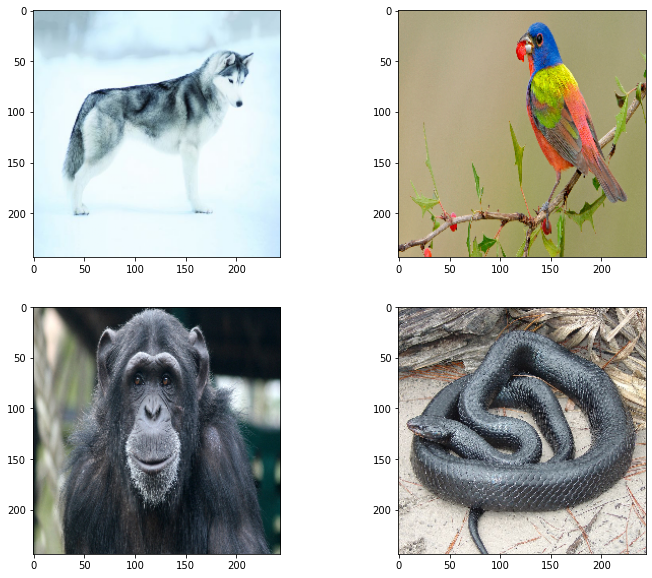

In [ ]:
from tensorflow.keras.preprocessing import image

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,10))
ax[0][0].imshow(NP_IMAGES_FOR_TEST['Husky'][0,...])
ax[0][1].imshow(NP_IMAGES_FOR_TEST['Bird'][0,...])
ax[1][0].imshow(NP_IMAGES_FOR_TEST['Monkey'][0,...])
ax[1][1].imshow(NP_IMAGES_FOR_TEST['Snake'][0,...])
fig.show()


In [ ]:
result = model(preprocess_input(NP_IMAGES_FOR_TEST['Husky']))

In [ ]:
decode_predictions(result)

AttributeError: ignored